<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gnb.configuration()

Library,Version
OS,nt [win32]
Python,"3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]"
IPython,7.21.0
MatPlotLib,3.3.4
Numpy,1.20.1
pyAgrum,0.19.3.9


# Credal Net from BN

In [29]:
bn=gum.fastBN("A->B[3]->C<-D<-A->E->F")
bn_min=gum.BayesNet(bn)
bn_max=gum.BayesNet(bn)
for n in bn.nodes():
  bn_min.cpt(n).scale(0.9)
  bn_max.cpt(n).scale(1.1)
    
cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()

gnb.sideBySide(bn.cpt("B"),bn_min.cpt("B"),bn_max.cpt("B"))
cn

(gum::credal::CredalNet<double>@00000152B3B5F240) 
A[0,1]
<> : [[0.353303 , 0.646697] , [0.431812 , 0.568188]]

B[0,2]
<A:0> : [[0.293307 , 0.0954569 , 0.611236] , [0.358486 , 0.0954569 , 0.546057] , [0.293307 , 0.11667 , 0.590023] , [0.358486 , 0.11667 , 0.524844]]
<A:1> : [[0.12856 , 0.390582 , 0.480858] , [0.12856 , 0.462012 , 0.409427] , [0.14456 , 0.462012 , 0.393428] , [0.15713 , 0.449442 , 0.393428] , [0.141132 , 0.37801 , 0.480858] , [0.15713 , 0.37801 , 0.46486]]

C[0,1]
<B:0|D:0> : [[0.34629 , 0.65371] , [0.423242 , 0.576758]]
<B:1|D:0> : [[0.479039 , 0.520961] , [0.573759 , 0.426241]]
<B:2|D:0> : [[0.422715 , 0.577285] , [0.51665 , 0.48335]]
<B:0|D:1> : [[0.528783 , 0.471217] , [0.61446 , 0.38554]]
<B:1|D:1> : [[0.161954 , 0.838046] , [0.197943 , 0.802057]]
<B:2|D:1> : [[0.583516 , 0.416484] , [0.65924 , 0.34076]]

D[0,1]
<A:0> : [[0.388676 , 0.611324] , [0.47505 , 0.52495]]
<A:1> : [[0.413822 , 0.586178] , [0.50578 , 0.49422]]

E[0,1]
<A:0> : [[0.609703 , 0.390297] , [0.680666 , 0.319334]]
<A:1> : [[0.203722 , 0.796278] , [0.248992 , 0.751008]]

F[0,1]
<E:0> : [[0.469242 , 0.530758] , [0.565744 , 0.434256]]
<E:1> : [[0.283948 , 0.716052] , [0.347048 , 0.652952]]

#### We can use LBP on CN (L2U) only for binary credal networks (here B is not binary). We then propose the classical binarization (but warn the user that this leads to approximation in the inference)

In [43]:
cn2=gum.CredalNet(bn_min,bn_max)
cn2.intervalToCredal()
cn2.approximatedBinarization()
cn2.computeCPTMinMax()

gnb.sideBySide(cn,cn2)

Here, $B$ becomes 
- $B$-b$i$ : the $i$-th bit of B
- instrumental $B$-v$k$ : the indicator variable for each modality $k$ of $B$

In [44]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie2_lbp=gum.CNLoopyPropagation(cn2)
ie2_mc=gum.CNMonteCarloSampling(cn2)

In [45]:
gnb.sideBySide(gnb.getInference(cn,ie_mc),gnb.getInference(cn2,ie2_mc),gnb.getInference(cn2,ie2_lbp))

In [46]:
gnb.sideBySide(ie_mc.CN(),ie_mc.marginalMin("F"),ie_mc.marginalMax("F"))
gnb.sideBySide(ie_mc.CN(),ie2_lbp.marginalMin("F"),ie2_lbp.marginalMax("F"))

In [42]:
1-0.3483

0.6517

## Credal Net from bif files

In [8]:
cn=gum.CredalNet(os.path.join("res","cn/2Umin.bif"),os.path.join("res","cn/2Umax.bif"))
cn.intervalToCredal()

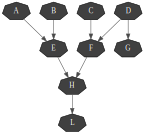

In [9]:
gnb.showCN(cn,"2")

In [10]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertEvidenceFile(os.path.join("res","cn/L2U.evi"))

In [11]:
ie.setRepetitiveInd(False)
ie.setMaxTime(1)
ie.setMaxIter(1000)

ie.makeInference()

In [12]:
gnb.sideBySide(cn,gnb.getInference(cn,targets={"A","H","L","D"},engine=ie,evs={"L":[0,1],"G":[1,0]}))

# Comparing inference in credal networks

In [13]:
import pyAgrum as gum

def showDiffInference(model,mc,lbp):
    for i in model.current_bn().nodes():
        a,b=mc.marginalMin(i)[:]
        c,d=mc.marginalMax(i)[:]
        
        e,f=lbp.marginalMin(i)[:]
        g,h=lbp.marginalMax(i)[:]
        
        plt.scatter([a,b,c,d],[e,f,g,h])
        

cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()
cn.computeBinaryCPTMinMax()

#### The two inference give quite the same result

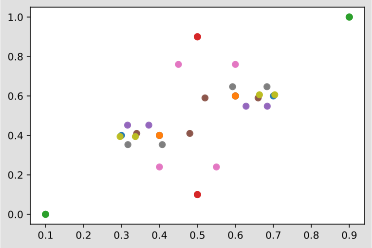

In [14]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)

#### but not when evidence are inserted

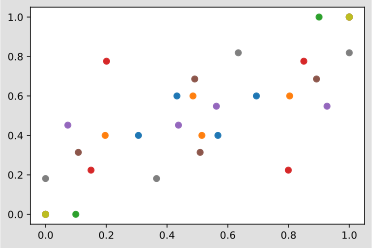

In [15]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.insertEvidenceFile("res/cn/L2U.evi")
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.insertEvidenceFile("res/cn/L2U.evi")
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)


## Dynamical Credal Net

In [16]:
cn=gum.CredalNet(os.path.join("res","cn/bn_c_8.bif"),os.path.join("res","cn/den_c_8.bif"))
cn.bnToCredal(0.8,False)

In [17]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(True)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()

In [18]:
print(ie.dynamicExpMax("temp"))

(13.796595328550666, 11.718137408680768, 11.99519389959661, 11.961533642299521, 11.965402073729585, 11.964973878078364, 11.965019991998949, 11.96501512083492, 11.96501567303239)


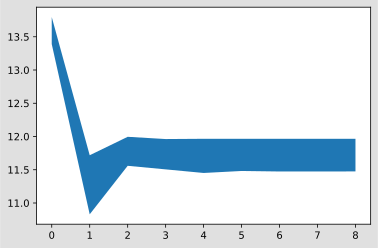

In [19]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

In [20]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()


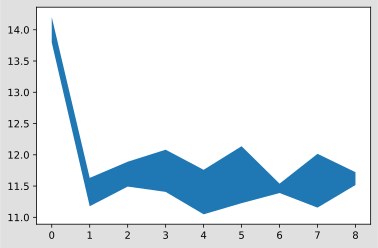

In [21]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

stopped with epsilon=0


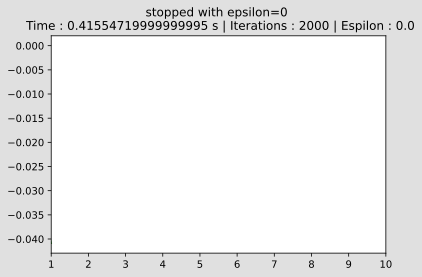

In [22]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(5000)

gnb.animApproximationScheme(ie)
ie.makeInference()
print(ie.messageApproximationScheme())

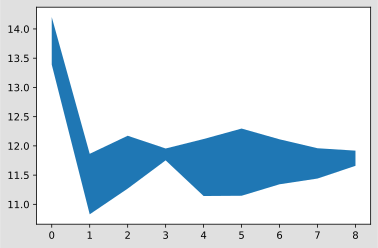

In [23]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"));